# Исследование сигналов управления на состояние объекта управления 

In [6]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from tqdm import tqdm

from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step, sinusoid

In [20]:
# Инициализация списка для хранения исторических данных
hist = []
dt = 0.1  # Интервал дискретизации времени

# Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=40, dt=dt) 

# Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# Вычисление общего количества временных шагов
number_time_steps = len(tp) 

# Создание заданного сигнала с использованием единичного шага
#reference_signals = np.reshape(unit_step(degree=1, tp=tp, time_step=5, output_rad=True), [1, -1])
reference_signals = np.reshape(np.deg2rad(sinusoid(amplitude=-0.008, tp=tp, frequency=1)), [1, -1])

# Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
env = gym.make('LinearLongitudinalF16-v0',
                number_time_steps=number_time_steps, 
                initial_state=[[0],[0]],
                reference_signal=reference_signals,
                output_space = ["theta",  "q",],
                state_space = ["theta", "q",  ],
                tracking_states=["theta"])

# Сброс среды к начальному состоянию
state, info = env.reset()

In [21]:
def cost_function(next_state, action, reference_signals, step):
    # Извлечение состояния системы
    theta, omega_z = next_state
    
    # Получение эталонного сигнала на данном шаге
    theta_ref = reference_signals[0][step]
    
    # Расчёт ошибки тангажа
    pitch_error = (theta - theta_ref) ** 2
    
    # Штраф за управление
    control_penalty = abs(action)
    
    # Включение штрафа за быстрое изменение угла (если это применимо)
    omega_penalty = omega_z ** 2
    
    # Взвешивание ошибок и штрафов
    cost = pitch_error + 0.01 * control_penalty + 0.01 * omega_penalty
    
    return cost


In [22]:
control_exploration_signal = np.reshape(unit_step(degree=10, tp=tp, time_step=1, dt=dt, output_rad=True), [1, -1])[0]
control_exploration_signal = np.reshape(np.deg2rad(sinusoid(amplitude=0.008, tp=tp, frequency=25)), [1, -1])[0]

states=[]
costs_list = []
actions=[]
next_states = []
state, info = env.reset()
for _ in tqdm(range(1)):
    state, info = env.reset()
    done = False
    index_exp_signal = 0
    for step in tqdm(range(number_time_steps-2)):
        action = control_exploration_signal[index_exp_signal]
        # action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step([action])
        cost = cost_function(next_state, action, reference_signals, step)
        costs_list.append(cost)
        done = terminated or truncated
        states.append(state)
        actions.append(action)
        next_states.append(next_state)
        state = next_state
        index_exp_signal+=1

  0%|          | 0/399 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


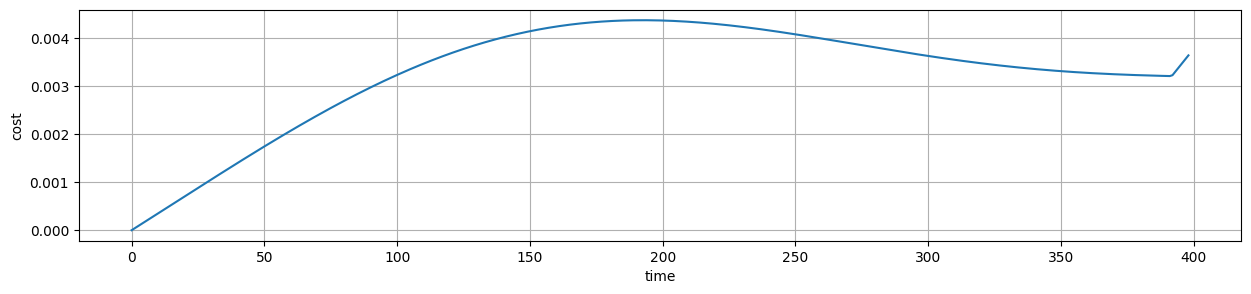

In [23]:
from matplotlib.pyplot import figure

figure(figsize=(15, 3))
plt.xlabel("time")
plt.ylabel("cost")

plt.plot(costs_list)
plt.grid(True)

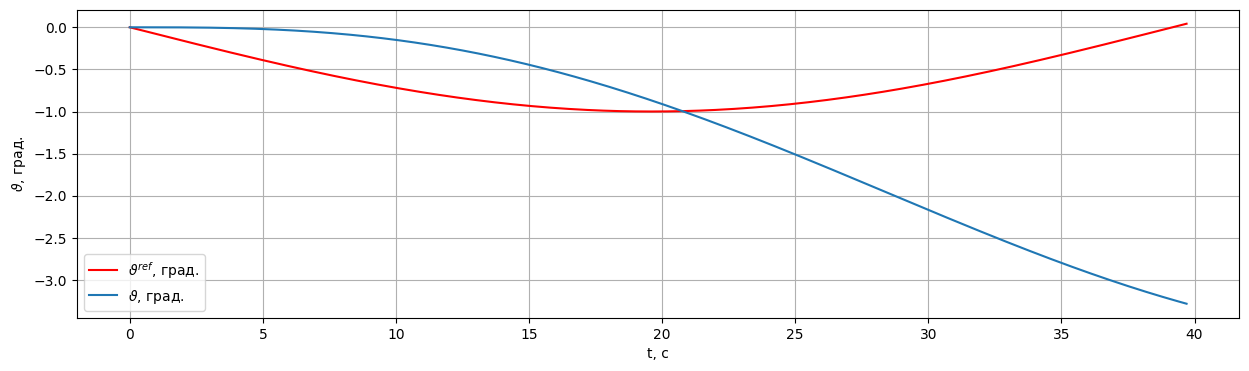

In [24]:
env.unwrapped.model.plot_transient_process('theta', tps, reference_signals[0], figsize=(15,4), to_deg=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


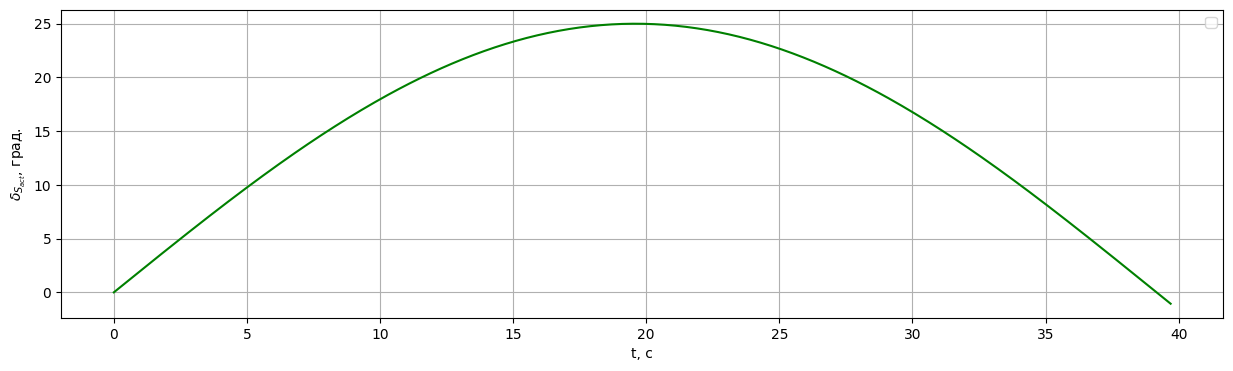

In [25]:
env.unwrapped.model.plot_control('ele', tps, to_deg=True, figsize=(15,4))

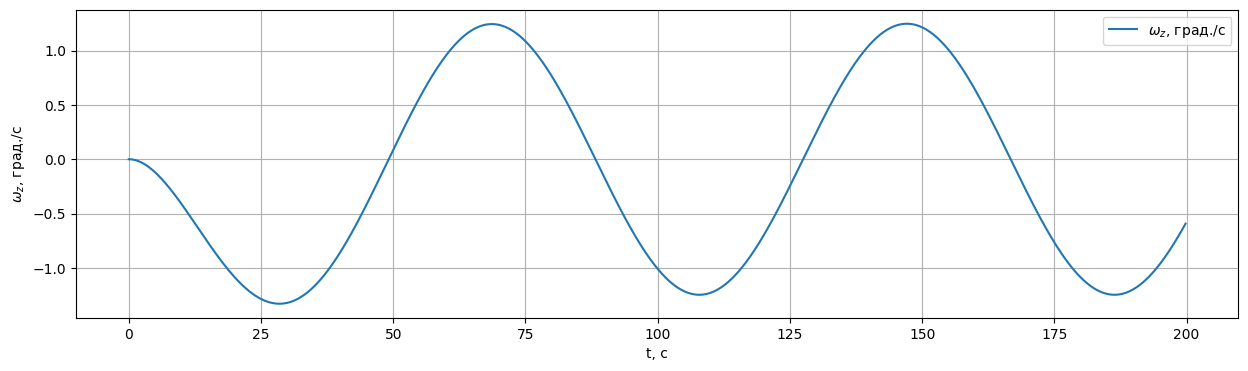

In [15]:
env.unwrapped.model.plot_state('q', tps, figsize=(15,4), to_deg=True)

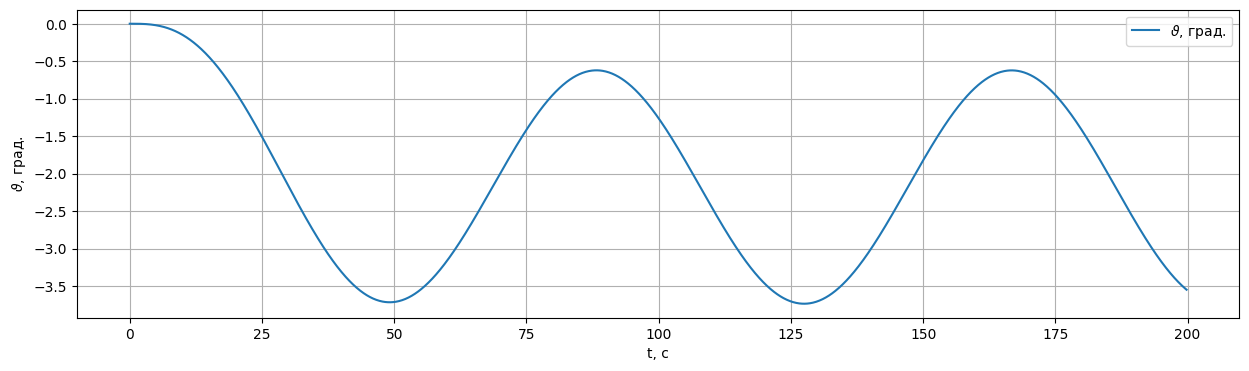

In [17]:
env.unwrapped.model.plot_state('theta', tps, figsize=(15,4), to_deg=True)

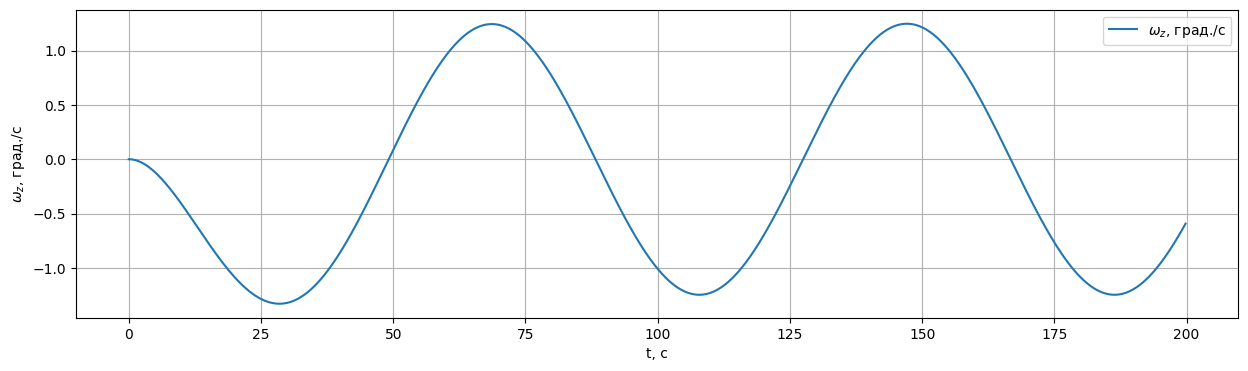

In [19]:
env.unwrapped.model.plot_state('q', tps, figsize=(15,4), to_deg=True)